Importing Required Libraries


In [1]:
import numpy as np
import skimage
from skimage import io , transform
import cv2
import keras
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import inception_v3
import skimage.segmentation
import copy
import sklearn.metrics
from sklearn.linear_model import LinearRegression

---
Function to Pre-Process Image



In [2]:
def process_img(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
  img = skimage.transform.resize(img, (299,299,3))
  img = (img - 0.5)*2 
  return img

---
Function to generate Perturbations of the Image

In [3]:
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

---
Input Image 

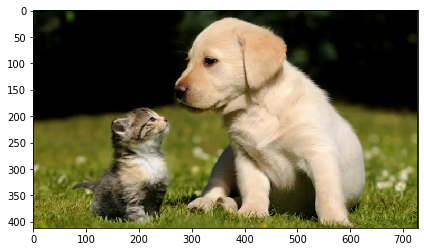

In [4]:
Inpimg = skimage.io.imread("/content/sample_data/Screenshot 2021-05-31 214731.png")
skimage.io.imshow(Inpimg)

In [5]:
Inpimg = process_img(Inpimg)
print("Shape of Image after Pre-Processing :", end=" ")
print(Inpimg.shape)

Shape of Image after Pre-Processing : (299, 299, 3)


---
Loading Pre-Trained Model

In [14]:
inceptionV3_model = keras.applications.inception_v3.InceptionV3() 
predicts = inceptionV3_model.predict(Inpimg[np.newaxis,:,:,:])
top_predict = predicts[0].argsort()[-5:][::-1] 
print("Top 5 predicted classes:")
decode_predictions(predicts, top=5)[0] 

Top 5 predicted classes:


[('n02099712', 'Labrador_retriever', 0.41882557),
 ('n02099601', 'golden_retriever', 0.38365665),
 ('n02104029', 'kuvasz', 0.010159289),
 ('n02101556', 'clumber', 0.00524543),
 ('n02101388', 'Brittany_spaniel', 0.004519153)]

---
Generating Superpixels and Perturbations of the Image

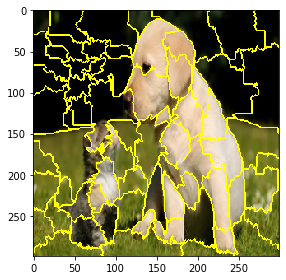

In [7]:
superpixels = skimage.segmentation.quickshift(Inpimg, kernel_size=4,max_dist=200, ratio=0.2)
num_super = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Inpimg/2+0.5, superpixels))

num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_super))

---
Examples of Perturbed Images

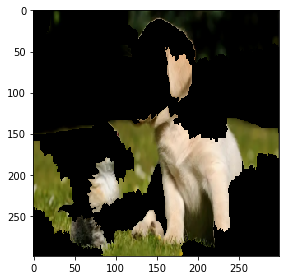

In [8]:
skimage.io.imshow(perturb_image(Inpimg/2+0.5,perturbations[34],superpixels))

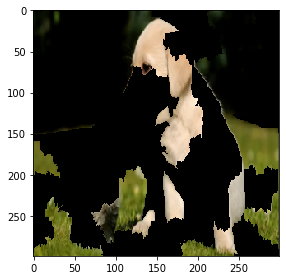

In [9]:
skimage.io.imshow(perturb_image(Inpimg/2+0.5,perturbations[88],superpixels))

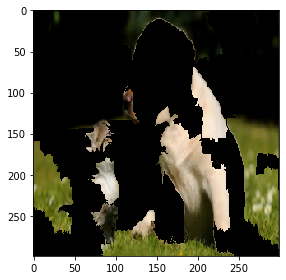

In [10]:
skimage.io.imshow(perturb_image(Inpimg/2+0.5,perturbations[140],superpixels))

---
Making Predictions using Inception_V3 Model



In [11]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Inpimg,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)


(150, 1, 1000)


---
1. Computing Distance(Relation) between Perturbed Image and Original Image
2. Converting these distances between 0 and 1 so that we can use them as weights for Training.



In [12]:
original_img = np.ones(num_super)[np.newaxis,:]  
distances = sklearn.metrics.pairwise_distances(perturbations,original_img, metric='cosine').ravel()
print(distances.shape)

kernel_wid = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_wid**2)) 
print(weights.shape)

(150,)
(150,)


---
Fitting a linear model for the Predictions , Perturbations and Weights.

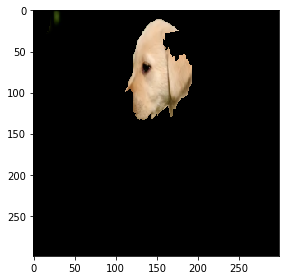

In [13]:
class_to_explain = top_predict[0] 
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

mask = np.zeros(num_super) 
mask[top_features]= True 
skimage.io.imshow(perturb_image(Inpimg/2+0.5,mask,superpixels))

**The Highlighted parts of the Image show that the Inception_V3 Model has predicted the correct class (`Labrador_retriever`) by extracting features from these parts of the Image.**